Stochastic Gradient Descent
======

In [1]:
import os
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

Parameter Settings
-------------------


In [2]:
num_epochs = 50
learning_rate = 1
batch_size = 50
use_gpu = False

Point Dataset
-------------------

Create a dataset of 2D points

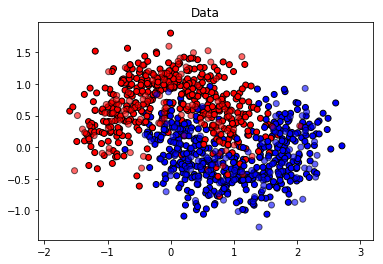

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
plt.ion()
from matplotlib.colors import ListedColormap

# create points
points, labels = make_moons(n_samples = 1000, noise=0.3, random_state=0)

# split into training- and test sets
train_points, test_points, train_labels, test_labels = \
    train_test_split(points, labels, test_size=.2, random_state=1)

# plot points
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
fig = plt.figure()
plt.scatter(train_points[:, 0], train_points[:, 1], c=train_labels, cmap=cm_bright, edgecolors='k')
plt.scatter(test_points[:, 0], test_points[:, 1], c=test_labels, cmap=cm_bright, alpha=0.6, edgecolors='k')
plt.title('Data')
plt.axis('equal')

train_points = torch.FloatTensor(train_points)
train_labels = torch.FloatTensor(train_labels).view(-1, 1)
test_points = torch.FloatTensor(test_points)
test_labels = torch.FloatTensor(test_labels).view(-1, 1)

train_dataset = list(zip(train_points, train_labels))
test_dataset = list(zip(test_points, test_labels))
# train_dataset = [(torch.FloatTensor(p), torch.FloatTensor([int(l)])) for p, l in zip(train_points, train_labels)]
# test_dataset = [(torch.FloatTensor(p), torch.FloatTensor([int(l)])) for p, l in zip(test_points, test_labels)]

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Linear Classifier Definition
-----------------------


In [4]:
linear_gd = nn.Linear(2, 1)
linear_sgd = nn.Linear(2, 1)

if use_gpu:
    linear_gd = linear_gd.cuda()
    linear_sgd = linear_sgd.cuda()

num_params = sum(p.numel() for p in linear_gd.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 3


Optimize (Train) Classifier with GD and SGD
--------
This training implements logisitic regression to train the linear classifier.

In [5]:
def training_step(classifier, points, labels):
    
    # logistic regression to optimize the linear classifier
    class_prob = F.sigmoid(classifier(points))

    # binary cross-entropy between the predicted class probabilities
    # and the ground truth class probabilities (which are 1 for a single class
    # and 0 for all other classes)
    loss = F.binary_cross_entropy(class_prob, labels)

    # backpropagation
    # this gives us the gradients of the loss w.r.t. the parameters
    # (gradients have to be set to zero first, since pytorch always adds
    # the computed gradients to the current gradients instead of replacing them)
    if classifier.weight.grad is not None:
        classifier.weight.grad.data.zero_()
        classifier.bias.grad.data.zero_()
    loss.backward()

    # gradient descent step (using the gradients from backpropagation)
    classifier.weight.data.add_(-learning_rate * classifier.weight.grad.data)
    classifier.bias.data.add_(-learning_rate * classifier.bias.grad.data)
    
    return loss

def train_classifier_gd(classifier):

    train_loss = []
    train_weights = []

    for epoch in range(num_epochs):

        points = Variable(train_points)
        labels = Variable(train_labels)
        if use_gpu:
            points = points.cuda()
            labels = labels.cuda()

        # gradient descent uses the entire dataset in each step
        loss = training_step(classifier, points, labels)
        
        # store loss and weights for visualization
        train_loss.append(loss.data[0])
        train_weights.append([
            classifier.weight.data[0, 0],
            classifier.weight.data[0, 1],
            classifier.bias.data[0]])

        print('Epoch [%d / %d] loss: %f' % (epoch+1, num_epochs, train_loss[-1]))
    
    return train_loss, train_weights

def train_classifier_sgd(classifier):

    train_loss = []
    train_loss_avg = []
    train_weights = []

    for epoch in range(num_epochs):
        train_loss_avg.append(0)
        num_batches = 0

        for point_batch, label_batch in train_dataloader:

            point_batch = Variable(point_batch)
            label_batch = Variable(label_batch)
            if use_gpu:
                point_batch = point_batch.cuda()
                label_batch = label_batch.cuda()
                
            # stochastic gradient descent uses one data point
            # or a minibatch of data points in each step
            loss = training_step(classifier, point_batch, label_batch)
            
            # store loss and weights for visualization
            train_loss.append(loss.data[0])
            train_loss_avg[-1] += loss.data[0]
            num_batches += 1
            train_weights.append([
                classifier.weight.data[0, 0],
                classifier.weight.data[0, 1],
                classifier.bias.data[0]])

        train_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] average loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    
    return train_loss, train_loss_avg, train_weights
        
print('Training linear classifier with GD ...')
train_loss_gd, train_weights_gd = train_classifier_gd(linear_gd)
print('Training linear classifier with SGD ...')
train_loss_sgd, train_loss_sgd_avg, train_weights_sgd = train_classifier_sgd(linear_sgd)


Training linear classifier with GD ...
Epoch [1 / 50] loss: 0.602428
Epoch [2 / 50] loss: 0.546918
Epoch [3 / 50] loss: 0.512362
Epoch [4 / 50] loss: 0.488075
Epoch [5 / 50] loss: 0.469636
Epoch [6 / 50] loss: 0.454951
Epoch [7 / 50] loss: 0.442880
Epoch [8 / 50] loss: 0.432736
Epoch [9 / 50] loss: 0.424068
Epoch [10 / 50] loss: 0.416565
Epoch [11 / 50] loss: 0.410000
Epoch [12 / 50] loss: 0.404204
Epoch [13 / 50] loss: 0.399047
Epoch [14 / 50] loss: 0.394430
Epoch [15 / 50] loss: 0.390269
Epoch [16 / 50] loss: 0.386501
Epoch [17 / 50] loss: 0.383074
Epoch [18 / 50] loss: 0.379943
Epoch [19 / 50] loss: 0.377072
Epoch [20 / 50] loss: 0.374431
Epoch [21 / 50] loss: 0.371995
Epoch [22 / 50] loss: 0.369740
Epoch [23 / 50] loss: 0.367649
Epoch [24 / 50] loss: 0.365706
Epoch [25 / 50] loss: 0.363894
Epoch [26 / 50] loss: 0.362204
Epoch [27 / 50] loss: 0.360624
Epoch [28 / 50] loss: 0.359144
Epoch [29 / 50] loss: 0.357756
Epoch [30 / 50] loss: 0.356452
Epoch [31 / 50] loss: 0.355226
Epoch [32

Show Trained Linear Classifiers
--------------------

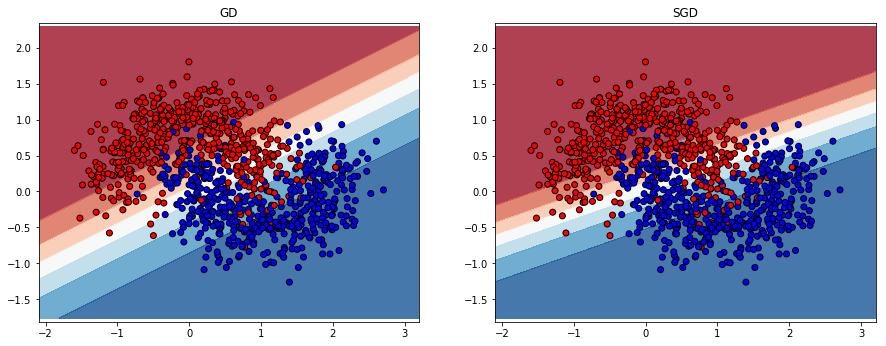

In [6]:
import matplotlib.pyplot as plt
import numpy as np
plt.ion()

# create points on a regular 2D grid
x_min, x_max = points[:, 0].min() - .5, points[:, 0].max() + .5
y_min, y_max = points[:, 1].min() - .5, points[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points = Variable(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))

if use_gpu:
    grid_points = grid_points.cuda()

# evaluate gd-trained classifier at all grid points
grid_class_prob_gd = F.sigmoid(linear_gd(grid_points))
if use_gpu:
    grid_class_prob_gd = grid_class_prob_gd.cpu()
grid_class_prob_gd = grid_class_prob_gd.data.numpy()
grid_class_prob_gd = grid_class_prob_gd.reshape(xx.shape)

# evaluate sgd-trained classifier at all grid points
grid_class_prob_sgd = F.sigmoid(linear_sgd(grid_points))
if use_gpu:
    grid_class_prob_sgd = grid_class_prob_sgd.cpu()
grid_class_prob_sgd = grid_class_prob_sgd.data.numpy()
grid_class_prob_sgd = grid_class_prob_sgd.reshape(xx.shape)

# plot class probabilities on the grid
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
fig = plt.figure(figsize=(15, 5.5))

ax = plt.subplot(1, 2, 1)
ax.contourf(xx, yy, grid_class_prob_gd, cmap=cm, alpha=.8)
ax.scatter(points[:, 0], points[:, 1], c=labels, cmap=cm_bright, edgecolors='k')
ax.set_title('GD')
ax.axis('equal')

ax = plt.subplot(1, 2, 2)
ax.contourf(xx, yy, grid_class_prob_sgd, cmap=cm, alpha=.8)
ax.scatter(points[:, 0], points[:, 1], c=labels, cmap=cm_bright, edgecolors='k')
ax.set_title('SGD')
ax.axis('equal')

print('')


Plot Training Curve
--------------------
This plot shows the loss with an equal numbers of processed data points. Since SGD updates the parameters more frequently (after looking at only a few points, not the entire dataset), it converges faster than full gradient descent.

Note that we could also increase the learning rate for GD to cover as much distance as SGD does in one epoch (that means multiplying the learning rate of GD by the number of minibatches in an epoch), but this results in a learning rate that is too large - taking one huge step with GD can easily overshoot the optimum.

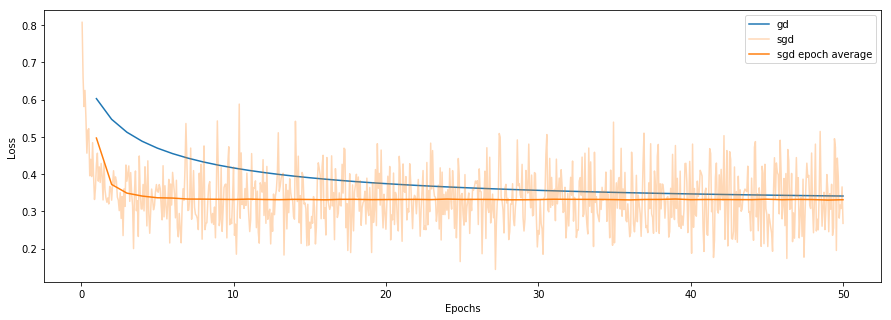

In [7]:
import matplotlib.pyplot as plt
import numpy as np
plt.ion()

fig = plt.figure(figsize=(15, 5))
plt.plot(np.linspace(1, num_epochs, len(train_loss_gd)),
         train_loss_gd, label='gd', color='#1f77b4')
plt.plot(np.linspace(num_epochs/len(train_loss_sgd), num_epochs, len(train_loss_sgd)),
         train_loss_sgd, label='sgd', alpha=0.3, color='#ff7f0e')
plt.plot(np.linspace(1, num_epochs, len(train_loss_sgd_avg)),
         train_loss_sgd_avg, label='sgd epoch average', color='#ff7f0e')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Show Path in Parameter Space
--------------------
This plot shows the path of one of the weight parameters and the bias over all iterations.

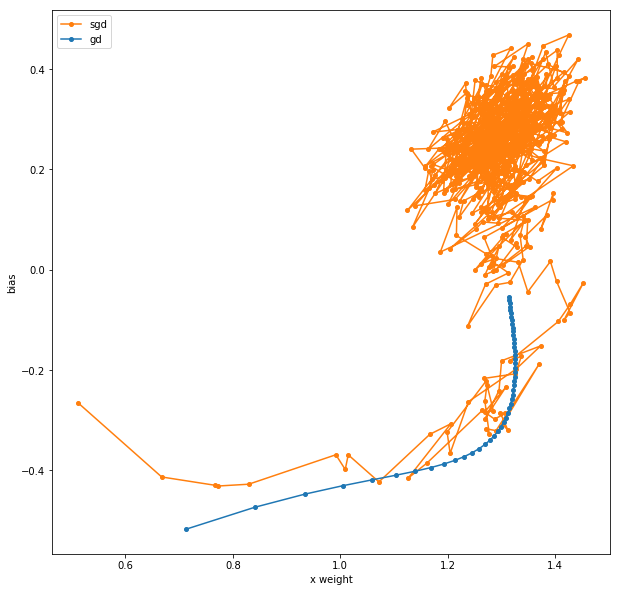

In [8]:
import matplotlib.pyplot as plt
import numpy as np
plt.ion()

params_gd = np.array(train_weights_gd)
params_sgd = np.array(train_weights_sgd)


fig = plt.figure(figsize=(10, 10))
plt.plot(params_sgd[:, 0], params_sgd[:, 2], label='sgd', marker='o', markersize=4, color='#ff7f0e')
plt.plot(params_gd[:, 0], params_gd[:, 2], label='gd', marker='o', markersize=4, color='#1f77b4')
plt.xlabel('x weight')
plt.ylabel('bias')
plt.legend(loc=2)
plt.show()
